# 프로젝트 : SRGAN 활용하기
## 🎯 루브릭 평가
1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.
2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.
3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.

In [12]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as Image
import tensorflow_datasets as tfds
from tensorflow.keras import Input, Model, layers
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.python.keras import applications
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from IPython.display import Image as show_gif

## 데이터 준비하기

In [13]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /aiffel/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


Text(0.5, 1.0, 'bicubic')

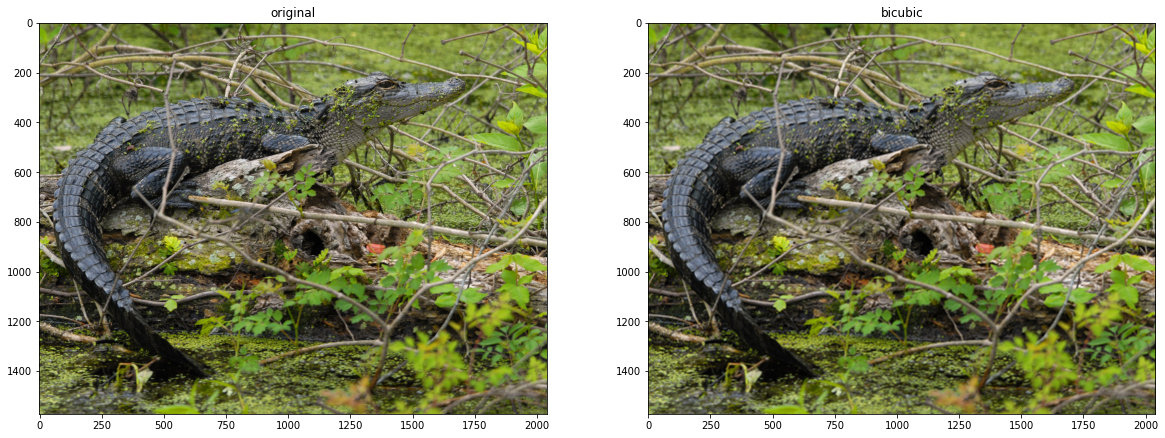

In [14]:
for i, (lr, hr) in enumerate(valid):
    if i == 1: break
        
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC     # bicubic 설정
)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(hr)
plt.title('original')
plt.subplot(1,2,2); plt.imshow(bicubic_hr)
plt.title('bicubic')

In [15]:
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

In [16]:
clean_train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
clean_valid = valid.map(preprocessing).repeat().batch(8)

## SRGAN 구현하기

In [17]:
# 파란색 블록
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

In [18]:
# 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)

In [19]:
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

In [20]:
# 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

In [21]:
# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

In [22]:
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

## SRGAN 학습하기

In [23]:
generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(clean_train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

80142336/80134624 [==============================] - 1s 0us/step
EPOCH[1] - STEP[10] 
Generator_loss:0.0011 
Discriminator_loss:2.0208

EPOCH[1] - STEP[20] 
Generator_loss:0.0013 
Discriminator_loss:1.4312

EPOCH[1] - STEP[30] 
Generator_loss:0.0017 
Discriminator_loss:1.0919

EPOCH[1] - STEP[40] 
Generator_loss:0.0021 
Discriminator_loss:0.8521

EPOCH[1] - STEP[50] 
Generator_loss:0.0025 
Discriminator_loss:0.6928

EPOCH[1] - STEP[60] 
Generator_loss:0.0030 
Discriminator_loss:0.5821

EPOCH[1] - STEP[70] 
Generator_loss:0.0035 
Discriminator_loss:0.5010

EPOCH[1] - STEP[80] 
Generator_loss:0.0038 
Discriminator_loss:0.4402

EPOCH[1] - STEP[90] 
Generator_loss:0.0040 
Discriminator_loss:0.3927

EPOCH[1] - STEP[100] 
Generator_loss:0.0042 
Discriminator_loss:0.3545

EPOCH[1] - STEP[110] 
Generator_loss:0.0044 
Discriminator_loss:0.3229

EPOCH[1] - STEP[120] 
Generator_loss:0.0045 
Discriminator_loss:0.2967

EPOCH[1] - STEP[130] 
Generator_loss:0.0047 
Discriminator_loss:0.2742

EPOCH[1]

In [24]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/srgan_G.h5
!mv srgan_G.h5 ~/aiffel/super_resolution

--2021-09-13 18:42:44--  https://aiffelstaticprd.blob.core.windows.net/media/documents/srgan_G.h5
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6578112 (6.3M) [application/x-hdf]
Saving to: ‘srgan_G.h5’

srgan_G.h5          100%[===================>]   6.27M  3.20MB/s    in 2.0s    

2021-09-13 18:42:47 (3.20 MB/s) - ‘srgan_G.h5’ saved [6578112/6578112]



## SRGAN 테스트하기

In [25]:
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [26]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

for i, (lr, hr) in enumerate(valid):
    if i == 1: break

srgan_hr = apply_srgan(lr)

In [39]:
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

Text(0.5, 1.0, 'srgan')

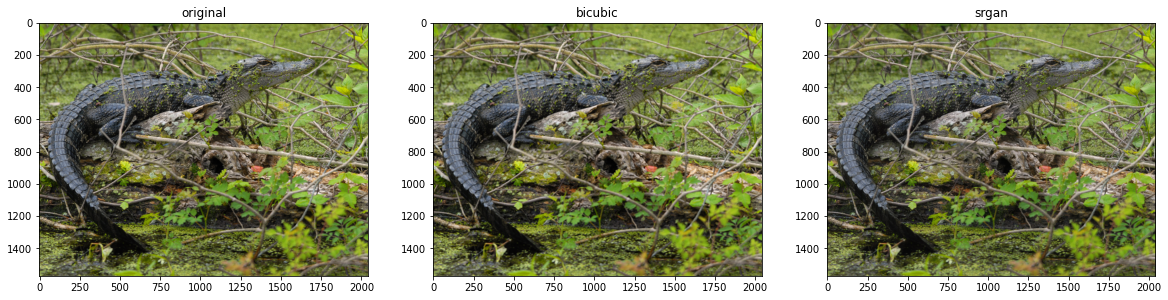

In [17]:
# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 1: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(hr)
plt.title('original')
plt.subplot(1,3,2); plt.imshow(bicubic_hr)
plt.title('bicubic')
plt.subplot(1,3,3); plt.imshow(srgan_hr)
plt.title('srgan')

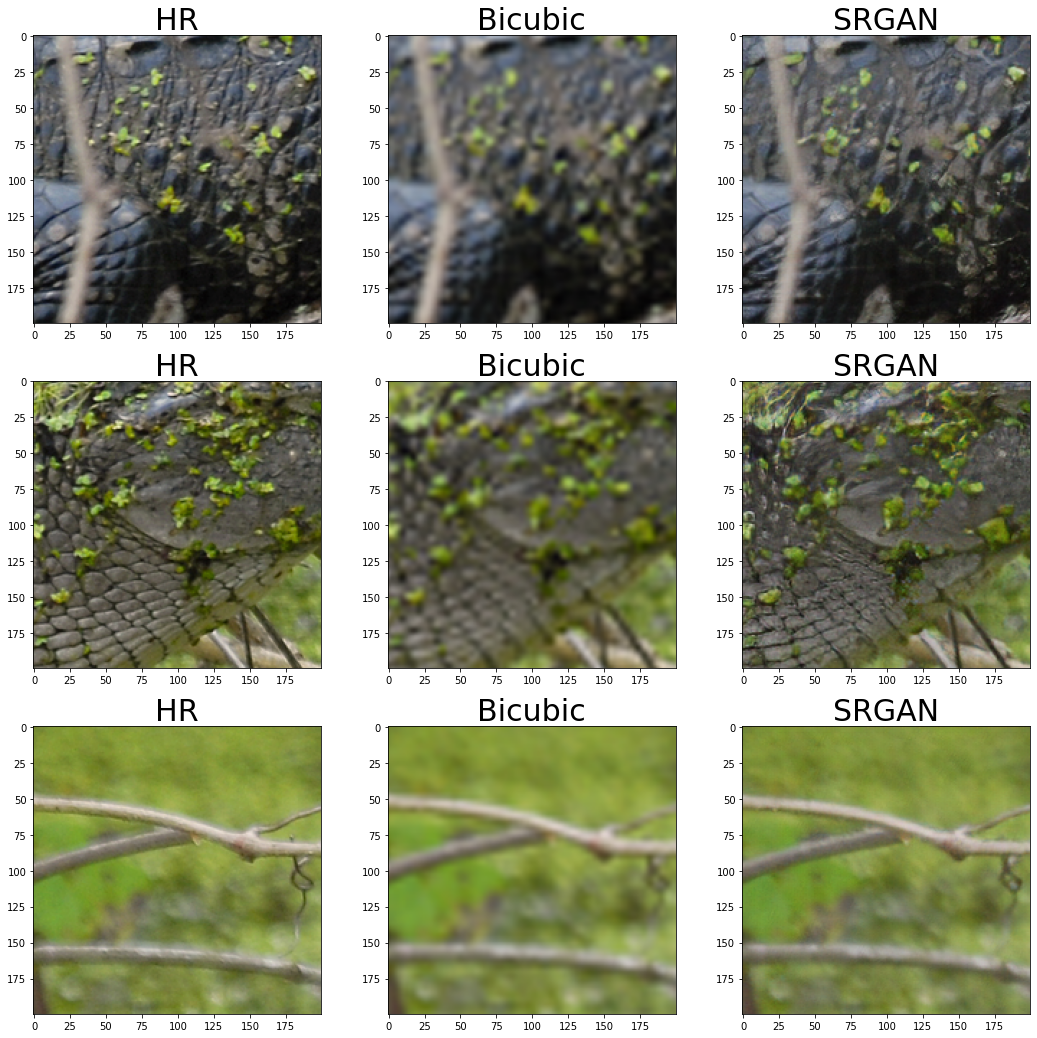

In [18]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(hr, left_top, 200, 200)
    img2 = crop(bicubic_hr, left_top, 200, 200)
    img3 = crop(srgan_hr , left_top, 200, 200)    
    images.extend([img1, img2, img3])

labels = ["HR", "Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
#### 1-1

1. 높은 해상도를 가진 이미지를 불러온다.

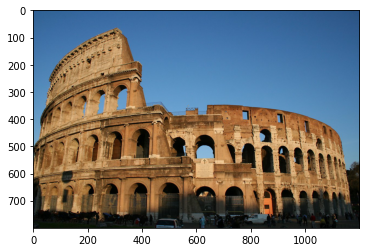

In [41]:
image_path = os.getenv('HOME')+'/aiffel/Git_Project/AIFFEL/exploration/image/ex16'
img = Image.imread(os.path.join(image_path, "Colosseum.jpeg"))

plt.imshow(img)
plt.show()

2. bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다.

In [42]:
height, width = img.shape[0], img.shape[1]
bicubic_image = cv2.resize(
    img, 
    dsize=(width//4, height//4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

3. 줄인 저해상도 이미지를 입력해 고해상도 이미지를 생성한다.

In [43]:
srgan_hr_ex1 = apply_srgan(bicubic_image)

4. 줄인 저해상도 이미지에 bicubic interpolation을 적용해 가로/세로를 4배로 늘린다.

In [44]:
height, width = bicubic_image.shape[0], bicubic_image.shape[1]
bicubic_hr = cv2.resize(
    bicubic_image, 
    dsize=(width*4, height*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

5. 원본이미지와 3,4번의 이미지를 시각화한다.

Text(0.5, 1.0, 'srgan')

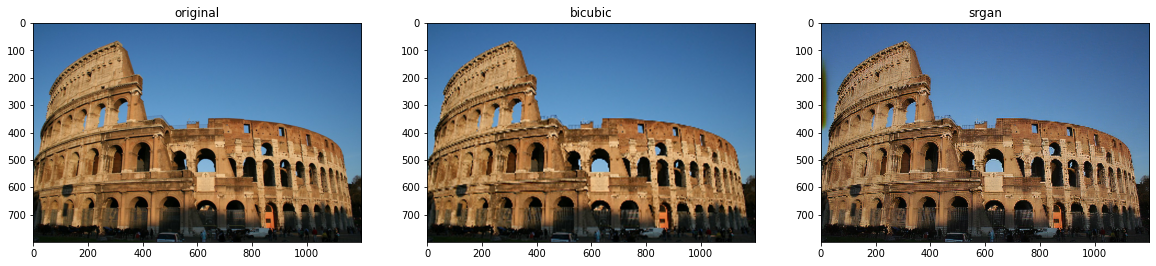

In [45]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(img)
plt.title('original')
plt.subplot(1,3,2); plt.imshow(bicubic_hr)
plt.title('bicubic')
plt.subplot(1,3,3); plt.imshow(srgan_hr_ex1)
plt.title('srgan')

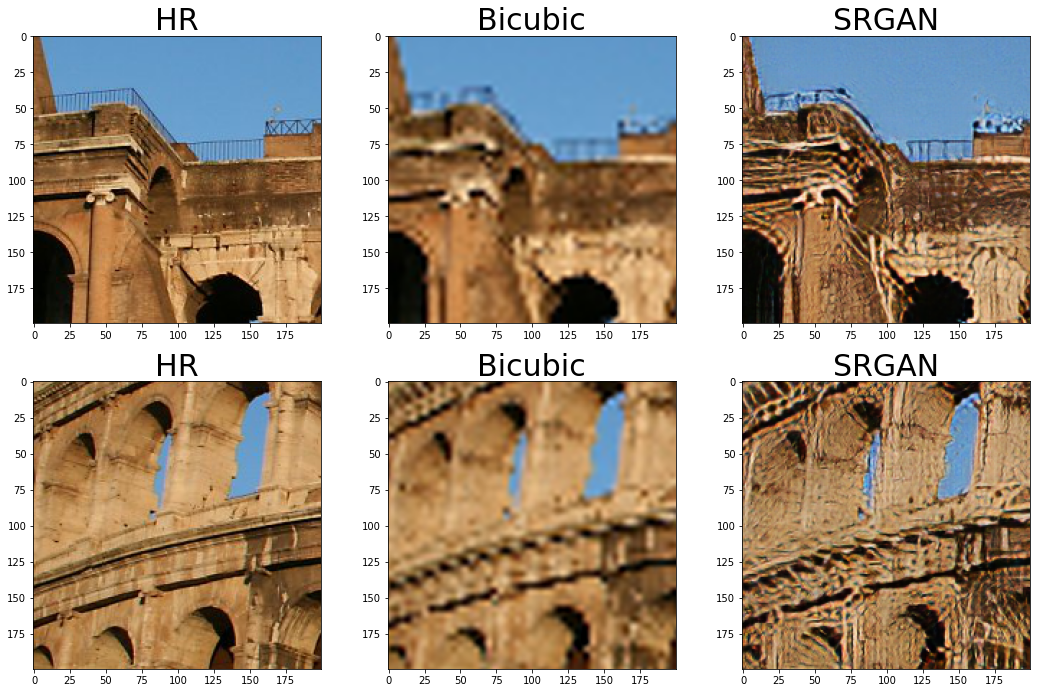

In [46]:
left_tops = [(300,400), (300,100)]

images = []
for left_top in left_tops:
    img1 = crop(img, left_top, 200, 200)
    img2 = crop(bicubic_hr, left_top, 200, 200)
    img3 = crop(srgan_hr_ex1 , left_top, 200, 200)    
    images.extend([img1, img2, img3])

labels = ["HR", "Bicubic", "SRGAN"] * 2

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

6. Super Resolution 결과 평가하기
* PSNR : 최대 신호에 대한 잡음의 비율을 나타낸다. 값이 높을 수록 좋다.
* SSIM : 구조 정보를 얼마나 변화시키지 않았는지를 계산한다. 값이 높을 수록 좋다.(값이 높을 수록 원본 영상의 품질에 가깝다는 의미)

In [25]:
def compare_image(x, y):
    print("PSNR :", peak_signal_noise_ratio(x, y))
    print("SSIM :", structural_similarity(x, y, multichannel=True))

In [26]:
print("**동일 이미지 비교**")
compare_image(img, img)

**동일 이미지 비교**
PSNR : inf


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


SSIM : 1.0


In [27]:
print("**원본이미지와 Bicubic 이미지 비교**")
compare_image(img, bicubic_hr)

**원본이미지와 Bicubic 이미지 비교**
PSNR : 24.077352056442642
SSIM : 0.7710885924178562


In [28]:
print("**원본이미지와 SRGAN 이미지 비교**")
compare_image(img, srgan_hr_ex1)

**원본이미지와 SRGAN 이미지 비교**
PSNR : 19.187654103105224
SSIM : 0.5659189327073036


전체적인 이미지로 Bicubic의 RSNR과 SSIM이 SRGAN보다 높은 것을 볼 수 있다.    
또 단순한 형태일 때는 잘 만들어내지만 복잡하면 잘 만들어내지 못하는 것을 볼 수 있었다.    
결론적으로 훈련은 잘 되었지만 새로운 데이터에 대해서는 제대로 만들지 못하는 것을 볼 수 있다.

#### 1-2
1. 낮은 이미지를 가져온다.

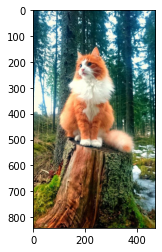

In [33]:
image_path = os.getenv('HOME')+'/aiffel/Git_Project/AIFFEL/exploration/image/ex16'
img = Image.imread(os.path.join(image_path, "cat_lr.jpeg"))

plt.imshow(img)
plt.show()

2. SRGAN을 이용해 고해상도 이미지를 생성한다.

In [34]:
srgan_hr_ex2 = apply_srgan(img)

3. 1번에서 불러온 이미지에 bicubic interpolation을 적용해 가로/세로를 4배로 늘린다.

In [35]:
height, width = img.shape[0], img.shape[1]
bicubic_hr = cv2.resize(
    img, 
    dsize=(width*4, height*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

4. Bicubic과 SRGAN 결과를 시각화한다.

In [36]:
img = cv2.resize(img, dsize=(bicubic_hr.shape[1], bicubic_hr.shape[0]))

Text(0.5, 1.0, 'srgan')

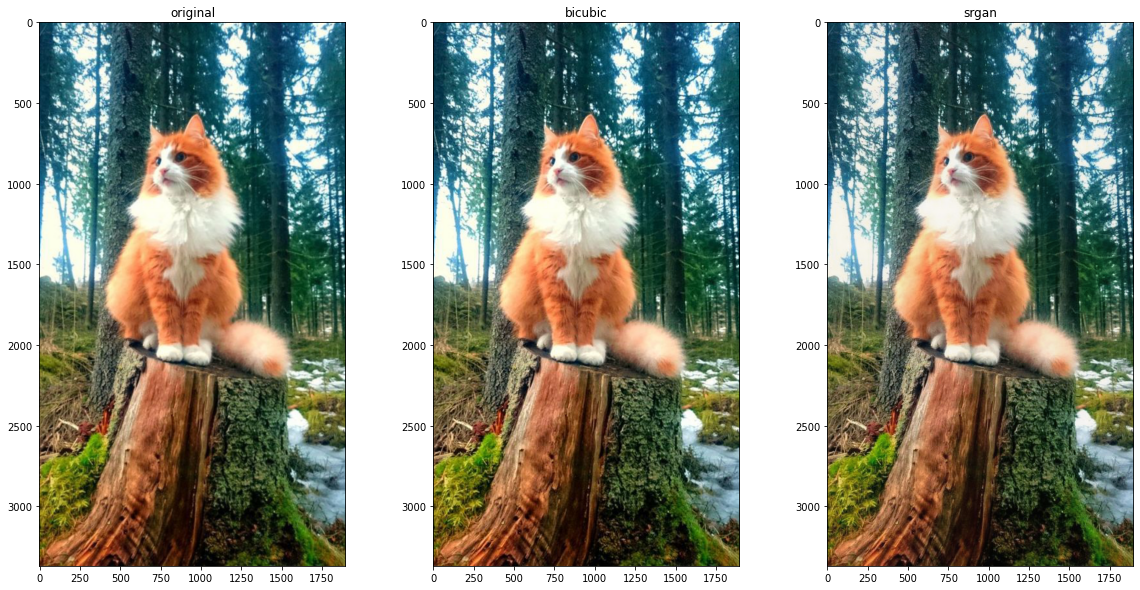

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(img)
plt.title('original')
plt.subplot(1,3,2); plt.imshow(bicubic_hr)
plt.title('bicubic')
plt.subplot(1,3,3); plt.imshow(srgan_hr_ex2)
plt.title('srgan')

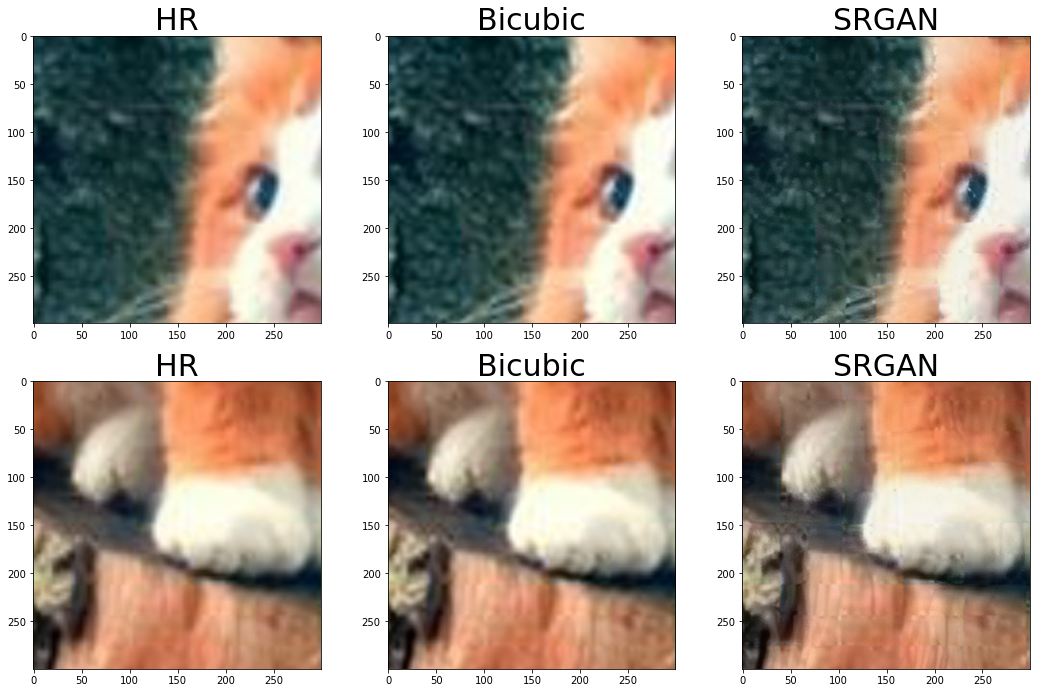

In [40]:
left_tops = [(700,500), (1900,600)]

images = []
for left_top in left_tops:
    img1 = crop(img, left_top, 300, 300)
    img2 = crop(bicubic_hr, left_top, 300, 300)
    img3 = crop(srgan_hr_ex2, left_top, 300, 300)    
    images.extend([img1, img2, img3])

labels = ["HR", "Bicubic", "SRGAN"] * 2

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

5. Super Resolution 결과 평가하기

In [35]:
print("**동일 이미지 비교**")
compare_image(img, img)

**동일 이미지 비교**
PSNR : inf
SSIM : 1.0


In [36]:
print("**원본이미지와 Bicubic 이미지 비교**")
compare_image(img, bicubic_hr)

**원본이미지와 Bicubic 이미지 비교**
PSNR : 38.55516743684865
SSIM : 0.9819146280827624


In [37]:
print("**원본이미지와 SRGAN 이미지 비교**")
compare_image(img, srgan_hr_ex2)

**원본이미지와 SRGAN 이미지 비교**
PSNR : 31.045716887411047
SSIM : 0.8869993846525953


bicubic은 사진상으로나 수치상으로나 원본과 비슷한 것을 볼 수 있다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

In [61]:
image_path = os.path.join(os.getcwd(),'image/ex16')

In [39]:
gif = cv2.VideoCapture(os.path.join(image_path, "metro_lr.gif"))
isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 35
frame 크기 : (252, 282, 3)


In [50]:
bicubic_gif = []
frames_sr_bicubic = []

for frame in frames:
    bicubic_hr = cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), # 고해상도 이미지 크기로 설정
        interpolation=cv2.INTER_CUBIC # bicubic 설정
    )
    bicubic_gif.append(bicubic_hr)
    frame = cv2.resize(
        lr, 
        dsize=(bicubic_hr.shape[1], bicubic_hr.shape[0]),
    )
    psnr = peak_signal_noise_ratio(frame, bicubic_hr)
    ssim = structural_similarity(frame, bicubic_hr, multichannel=True)
    frames_sr_bicubic.append((psnr, ssim))

In [51]:
srgan_gif = []
frames_sr_srgan = []
for frame in frames:
    srgan_hr_gif = apply_srgan(frame)
    srgan_gif.append(srgan_hr_gif)
    frame = cv2.resize(
        frame, 
        dsize=(srgan_hr_gif.shape[1], srgan_hr_gif.shape[0]),
    )
    psnr = peak_signal_noise_ratio(frame, srgan_hr_gif)
    ssim = structural_similarity(frame, srgan_hr_gif, multichannel=True)
    frames_sr_srgan.append((psnr, ssim))

In [52]:
import imageio

imageio.mimsave(os.path.join(image_path, "bicubic.gif"), bicubic_gif)
imageio.mimsave(os.path.join(image_path, "srgan.gif"), srgan_gif)

In [54]:
#show_gif(os.path.join(image_path, "metro_lr.gif"), width=300)

![metro_lr](https://user-images.githubusercontent.com/63278762/133177907-51592e03-0cda-498c-98d5-ac3aa742b583.gif)

In [55]:
#show_gif(os.path.join(image_path, "bicubic.gif"), width=300)

<img src="https://drive.google.com/uc?export=view&id=1EFxbMPLAwvmBGZr33zzCbaRK0NmJ_8LD" style="width: 300px; height: auto"/>

In [56]:
#show_gif(os.path.join(image_path, "srgan.gif"), width=300)

<img src="https://drive.google.com/uc?export=view&id=13aaaZspLBPFsAZY9rn7EQV20nnwrOOU1" style="width: 300px; height: auto"/>

Super Resolution 결과 평가하기

In [58]:
# 원본과 비교
origin_psnr = []
origin_ssim = []
for frame in frames:
    psnr = peak_signal_noise_ratio(frame, frame)
    ssim = structural_similarity(frame, frame, multichannel=True)
    origin_psnr.append(psnr)
    origin_ssim.append(ssim)

In [59]:
print('**Origin**')
print(f'PSNR : {round(np.mean(origin_psnr), 2)}')
print(f'SSIM : {round(np.mean(origin_ssim), 2)}')

**Origin**
PSNR : inf
SSIM : 1.0


In [60]:
print('**Bicubic**')
bicubic_psnr = [psnr for psnr, ssim in frames_sr_bicubic]
bicubic_ssim = [ssim for psnr, ssim in frames_sr_bicubic]
print(f'PSNR : {round(np.mean(bicubic_psnr), 2)}')
print(f'SSIM : {round(np.mean(bicubic_ssim), 2)}')
print('**SRGAN**')
srgan_psnr = [psnr for psnr, ssim in frames_sr_srgan]
srgan_ssim = [ssim for psnr, ssim in frames_sr_srgan]
print(f'PSNR : {round(np.mean(srgan_psnr), 2)}')
print(f'SSIM : {round(np.mean(srgan_ssim), 2)}')

**Bicubic**
PSNR : 10.78
SSIM : 0.17
**SRGAN**
PSNR : 26.6
SSIM : 0.77


평가 결과 SRGAN이 더 원본과 유사하게 만든 것을 확인할 수 있었다.

# 회고
## 배운 내용
* SRGAN과 SRCNN에 대해서 배웠다.
* gif파일에서 프레임을 가져오고, gif파일 만드는 것을 배웠다.
* RSNR과 SSIM이 무엇인지 배웠다.

## 느낀 점
* 학습시킨 이미지 종류에서만 잘 학습을 한다는 것이 아쉬웠다.
* 이미지가 SRGAN을 사용하니 너무 자글자글해지는게 너무 아쉬웠다.
* 신기하게 gif파일은 제대로 고화질로 만들어준 것을 보고 단순한 이미지는 잘 만들어내지만 복잡한 이미지는 잘 만들어내지 못한다는 것을 알았다. 

# Reference
* https://bskyvision.com/396
* https://www.youtube.com/watch?v=nGPMKnoJTcI
* https://bskyvision.com/789